In [1]:
"""
This script generates classroom-wide LLM-generated reports based on accumulative metrics by
grouping students by their performance
"""

import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ollama
from readability import Readability

# Make matplotlib dark mode
plt.style.use('dark_background')

In [2]:
# Load the dataset
dfs = pd.read_excel('./data/accumulative_metrics.xlsx', sheet_name=None)

In [3]:
# Preprocessing
assignment_names = ['Suffrage', 'Ants', 'Clouds', 'Waterclocks', 'Lizards', 'Tastes', 'Lodgepoles']
all_dfs = []

# Keep only the top features
with open('top_features.json', 'r') as f:
    top_features = json.load(f)['features']

print([x for x in top_features])

for assignment_name in assignment_names:
    df = dfs[assignment_name]
    assignment_top_features = [f"{assignment_name}_{x}" for x in top_features]
    df = df[['id', f"{assignment_name}_score"] + assignment_top_features]
    df['assignment'] = assignment_name
    all_dfs.append(df)

# Add student attributes and join via 'id
student_attributes = pd.read_excel('./data/student_attributes.xlsx')
all_dfs = [df.merge(student_attributes, on='id', how='left') for df in all_dfs]

# Show 'Suffrage' df
print(all_dfs[0].head())

['total_forward_wpm_mean', 'coldread_net_wpm_std', 'coldread_coverage_word_%', 'qa_fix_dispersion_mean', 'qa_saccade_vertical_next_target_%']
    id  Suffrage_score  Suffrage_total_forward_wpm_mean  \
0  103        0.666667                           287.93   
1  104        0.444444                           256.99   
2  105        0.444444                           288.92   
3  108        0.444444                           229.73   
4  109        0.388889                           271.11   

   Suffrage_coldread_net_wpm_std  Suffrage_coldread_coverage_word_%  \
0                         211.02                              33.72   
1                         225.77                              24.46   
2                         193.10                              18.38   
3                         212.52                              12.45   
4                         197.33                              16.06   

   Suffrage_qa_fix_dispersion_mean  \
0                             1.93   


/var/folders/wg/5f3q13d11215w5syssg034n80000gn/T/ipykernel_51324/843738164.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['assignment'] = assignment_name
/var/folders/wg/5f3q13d11215w5syssg034n80000gn/T/ipykernel_51324/843738164.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['assignment'] = assignment_name
/var/folders/wg/5f3q13d11215w5syssg034n80000gn/T/ipykernel_51324/843738164.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

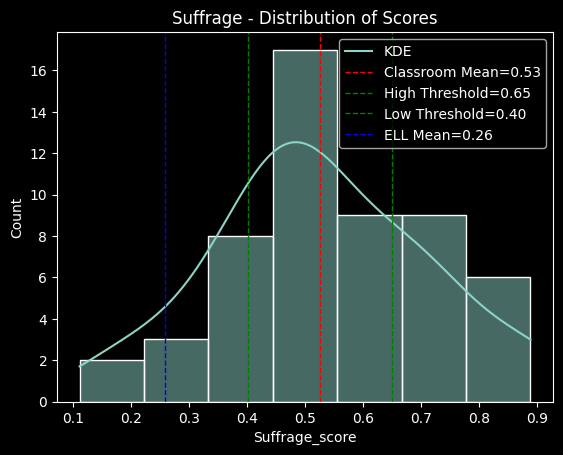

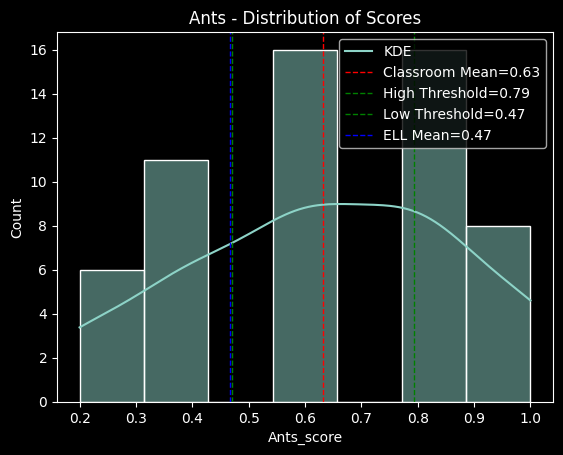

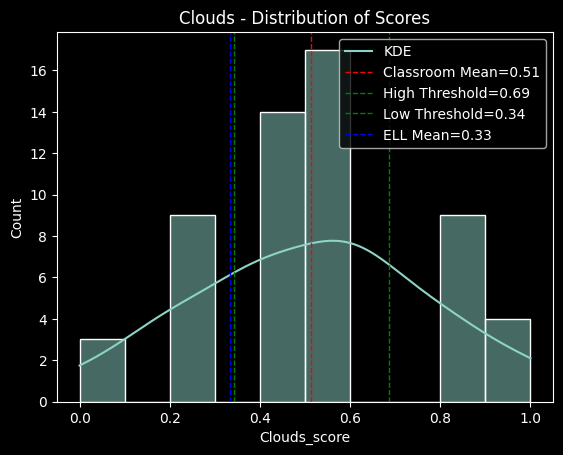

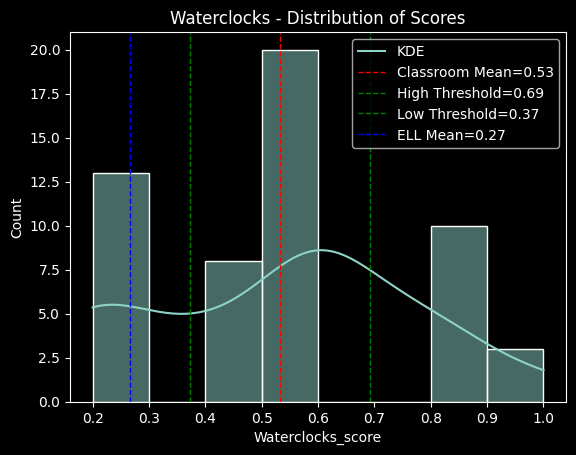

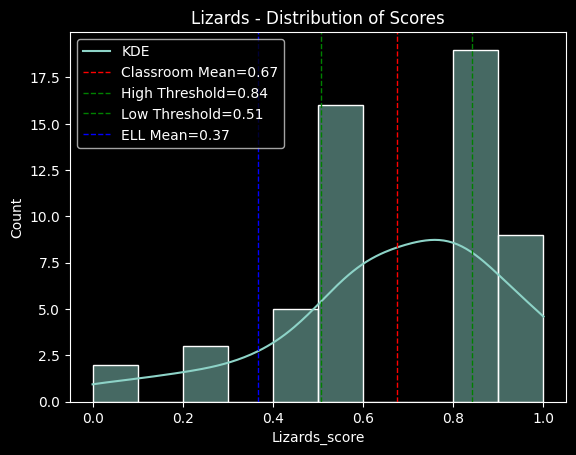

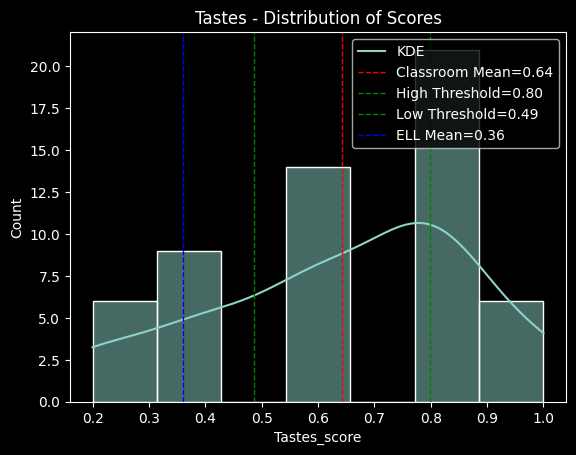

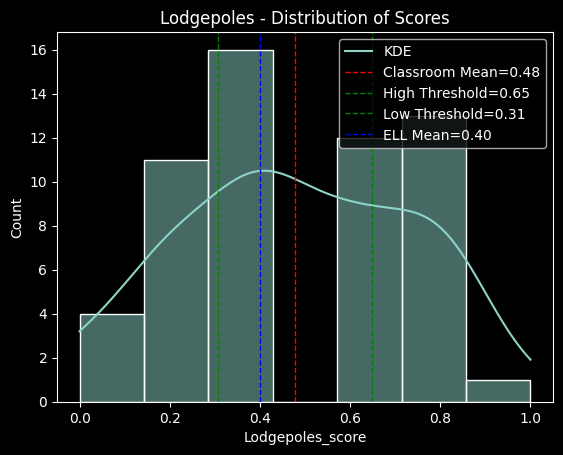

In [4]:
# For each assignment, perform the same processing
for assignment_name, df in zip(assignment_names, all_dfs):

    # Generate groups based on the mean and std thresholds and plot the distribution of the group scores
    mean = df[f'{assignment_name}_score'].mean()
    std = df[f'{assignment_name}_score'].std()
    high_threshold = mean + std/1.5
    low_threshold = mean - std/1.5

    # Create a new figure for each assignment
    plt.figure()

    # Plot the distribution of the scores
    sns.histplot(df[f'{assignment_name}_score'], kde=True)

    # Add the mean and median
    plt.axvline(mean, color='r', linestyle='dashed', linewidth=1, label='Classroom Mean')

    # Add the thresholds
    plt.axvline(high_threshold, color='g', linestyle='dashed', linewidth=1)
    plt.axvline(low_threshold, color='g', linestyle='dashed', linewidth=1)

    # Plot the mean score for special groups (Disability and ELL)
    ell_mean = df[df['ELL'] == 'Yes'][f'{assignment_name}_score'].mean()
    plt.axvline(ell_mean, color='b', linestyle='dashed', linewidth=1, label='ELL Mean')

    # Add legend with the values
    plt.legend({
        f"KDE": None,
        f'Classroom Mean={mean:.2f}': mean,
        f'High Threshold={high_threshold:.2f}': high_threshold,
        f'Low Threshold={low_threshold:.2f}': low_threshold,
        f'ELL Mean={ell_mean:.2f}': ell_mean
    })
    plt.title(f'{assignment_name} - Distribution of Scores')

    # Show the plot
    plt.show()

In [5]:
for assignment_name, df in zip(assignment_names, all_dfs):
    df['group'] = ''
    df.loc[df[f'{assignment_name}_score'] > high_threshold, 'group'] = 'H' # High Performers
    df.loc[(df[f'{assignment_name}_score'] <= high_threshold) & (df[f'{assignment_name}_score'] > low_threshold), 'group'] = 'M' # Medium Performers
    df.loc[(df[f'{assignment_name}_score'] <= low_threshold), 'group'] = 'L' # Low Performers
    df.head(10)

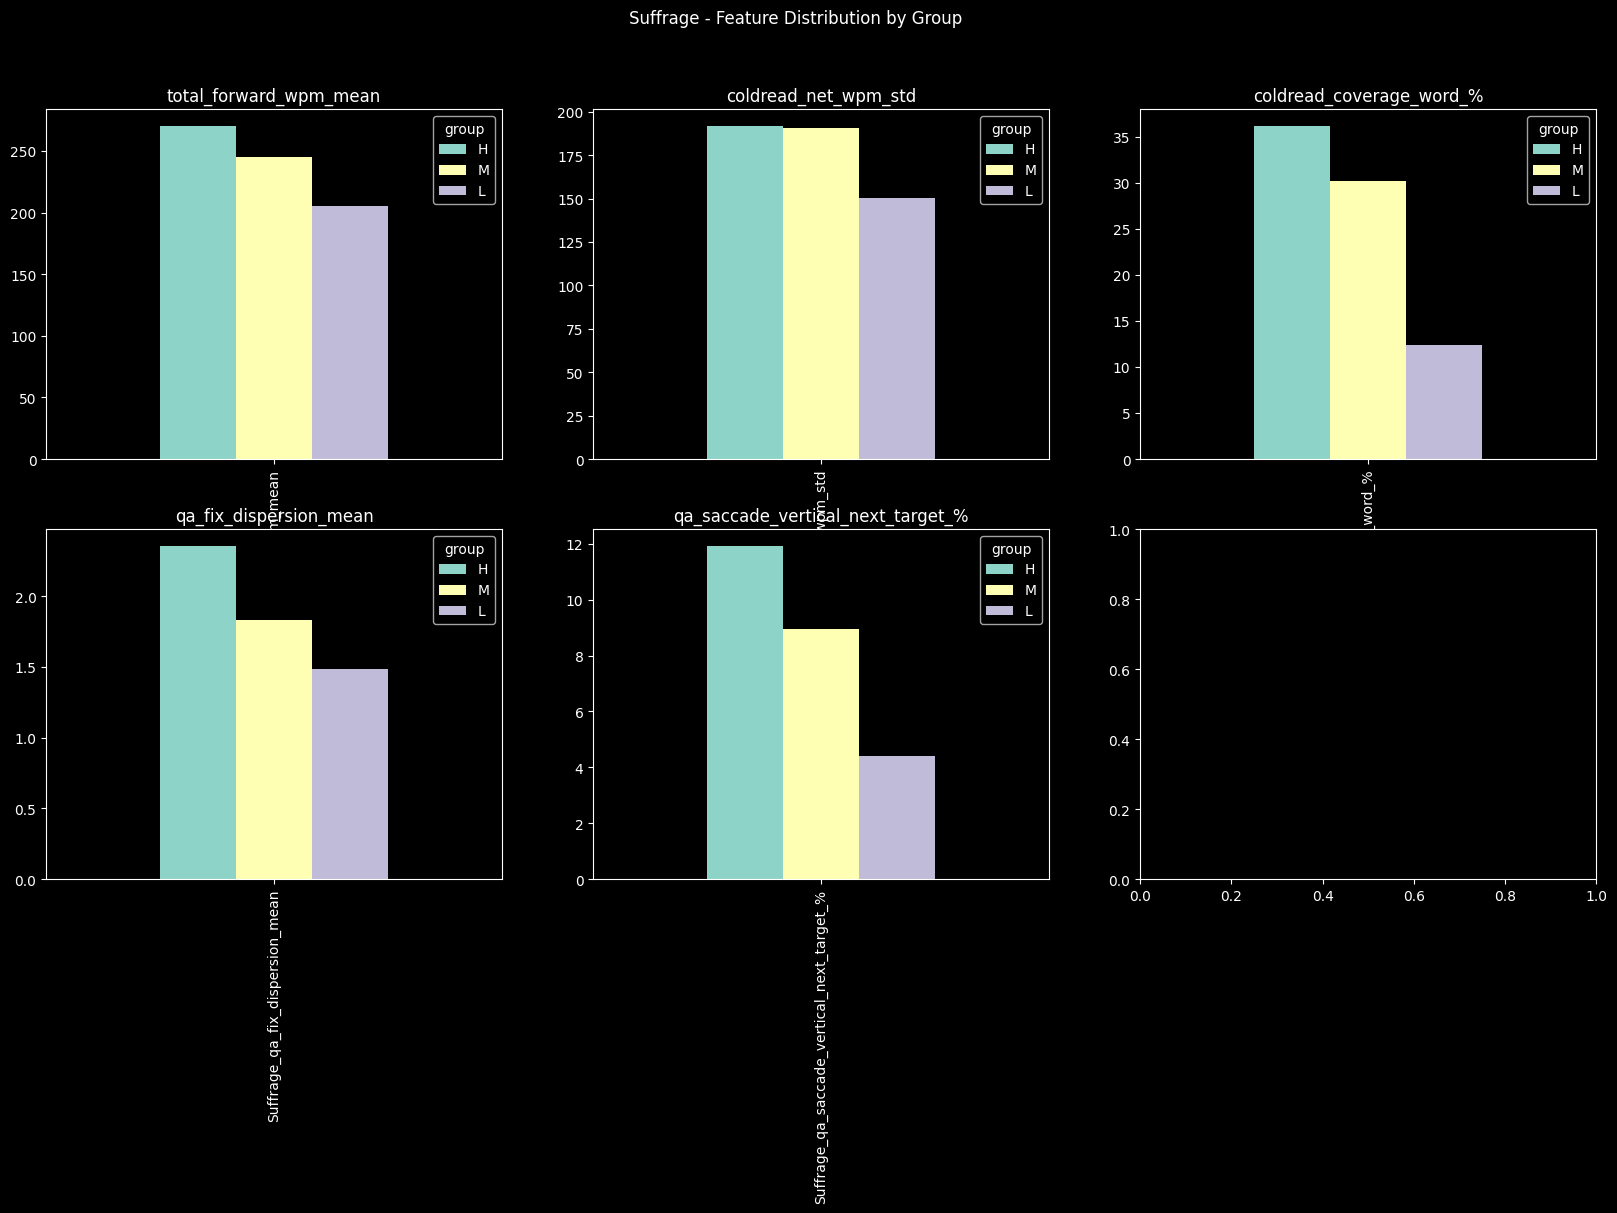

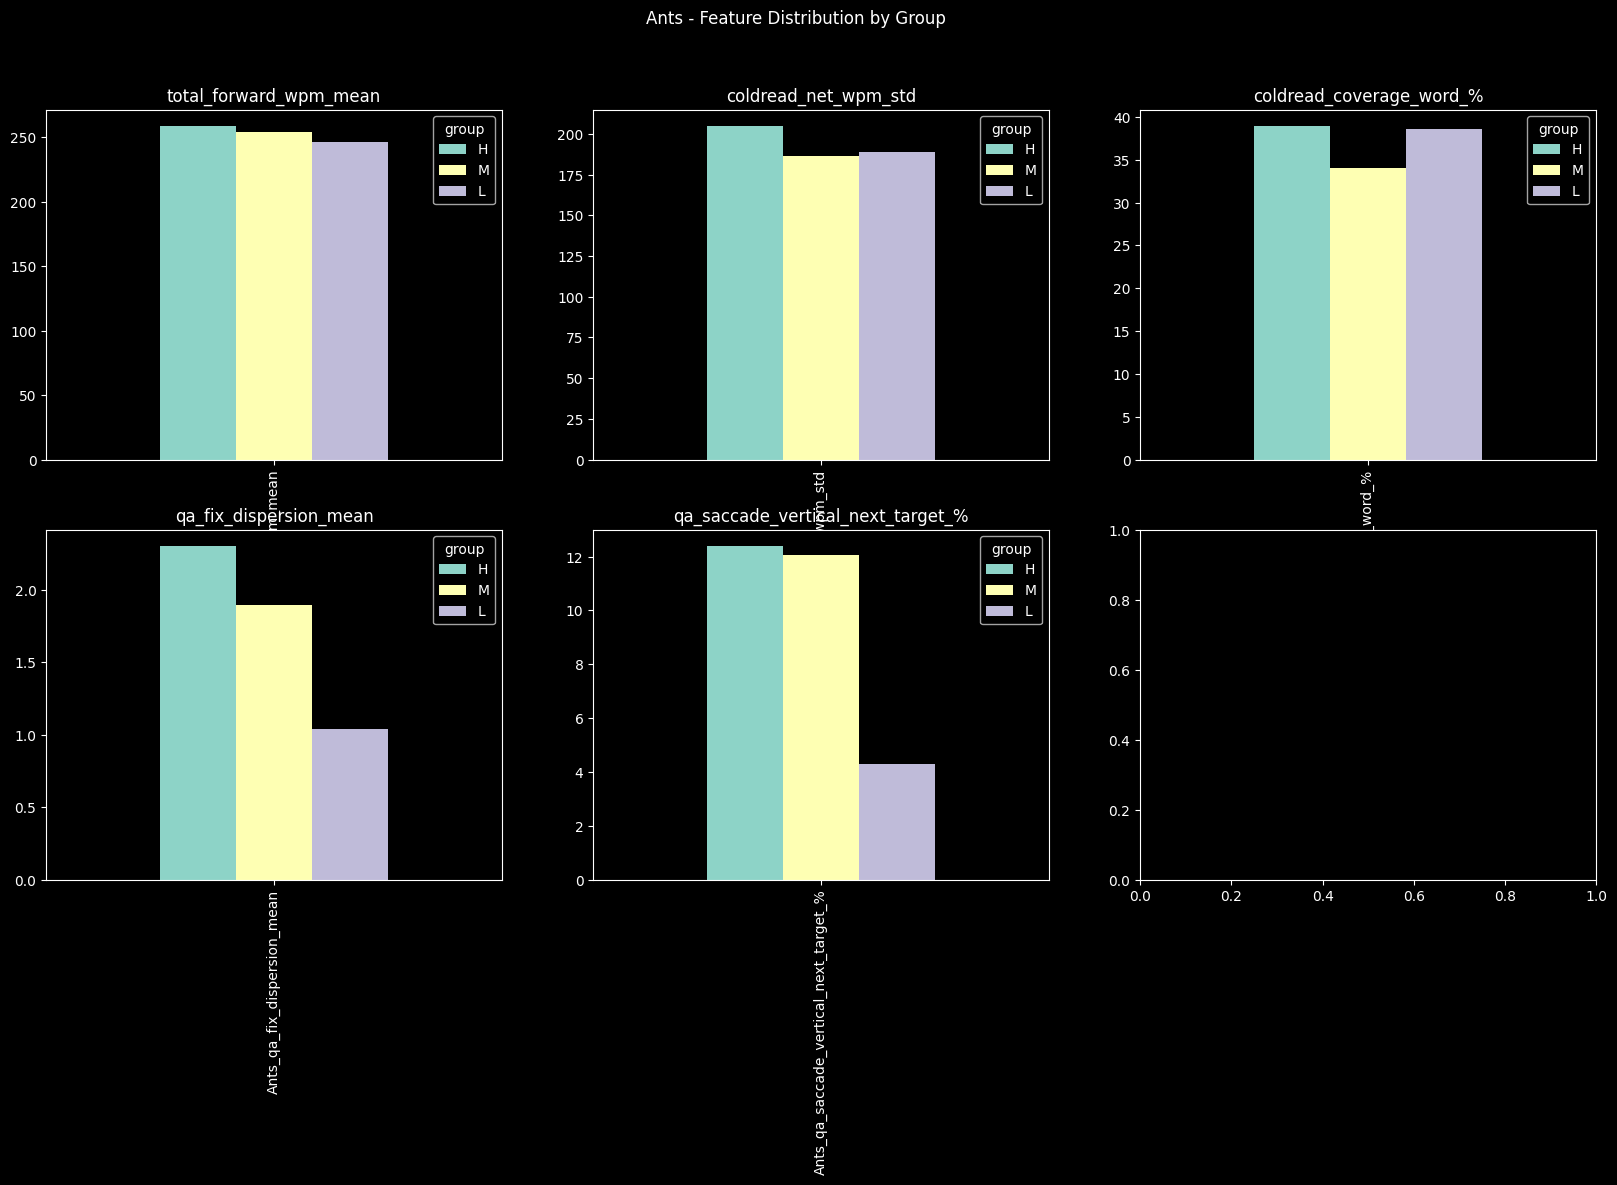

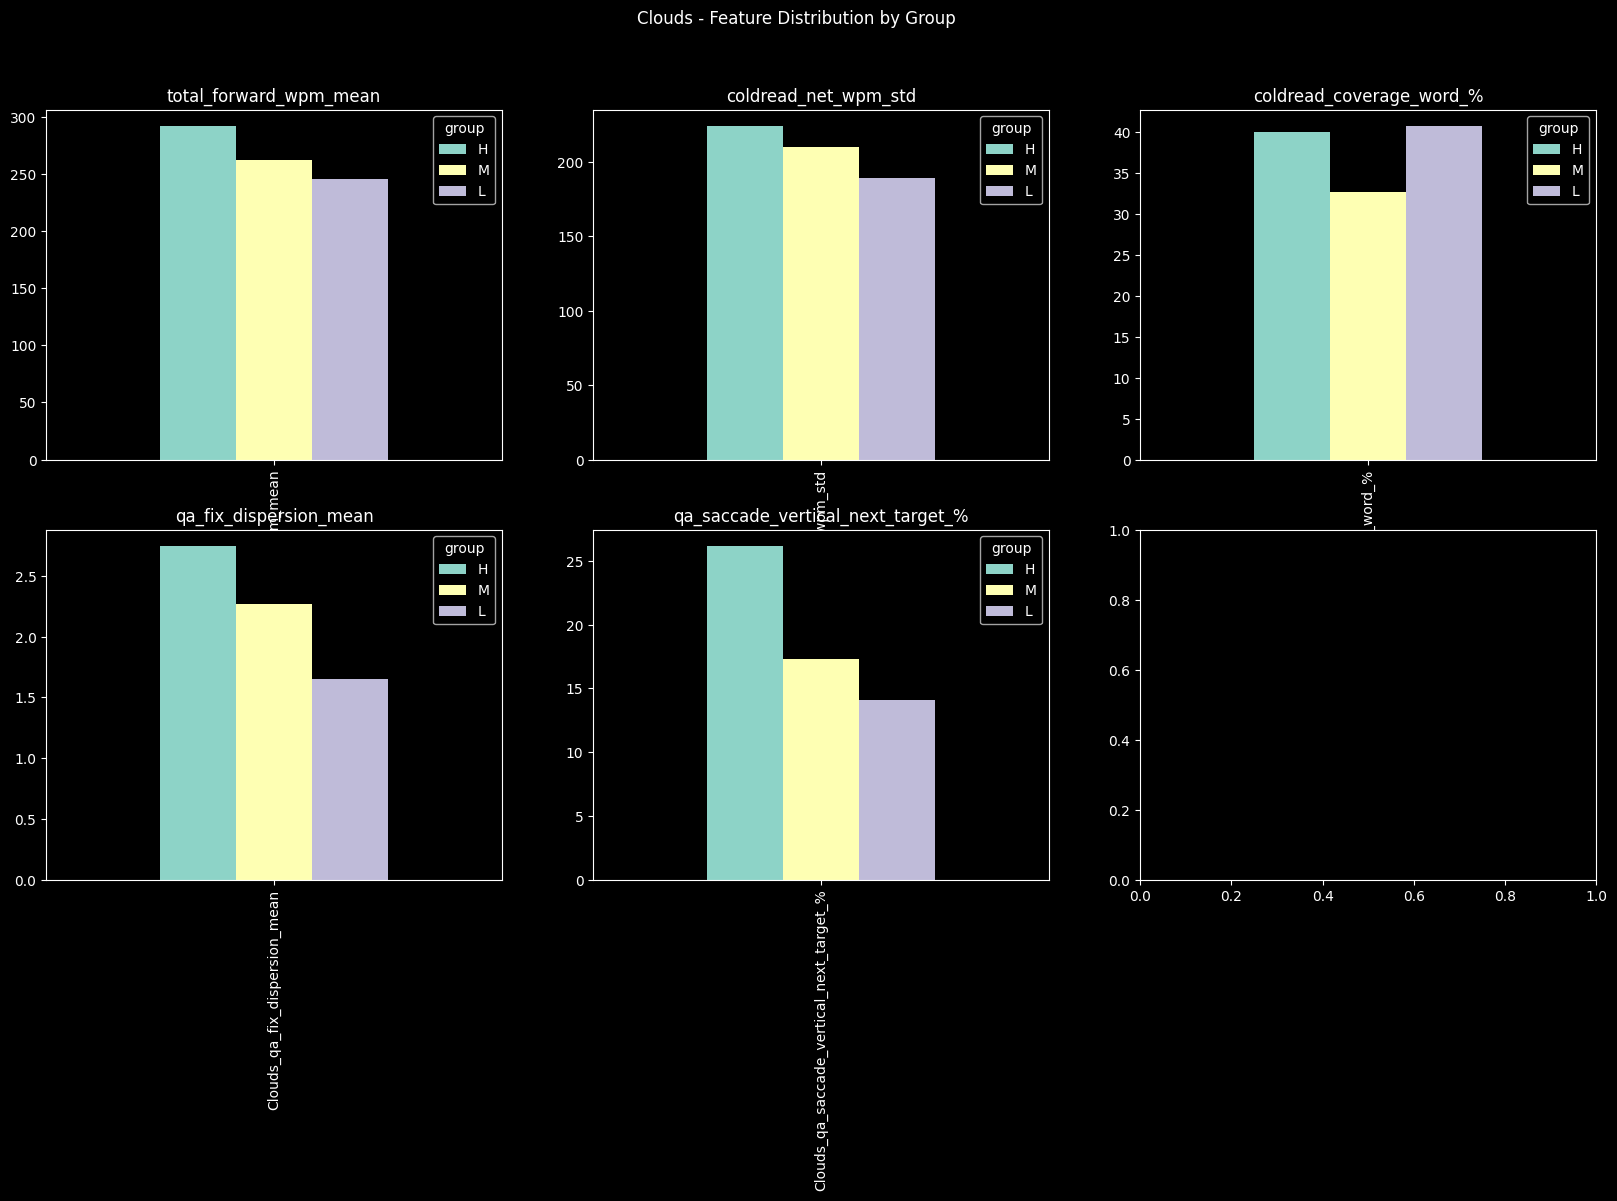

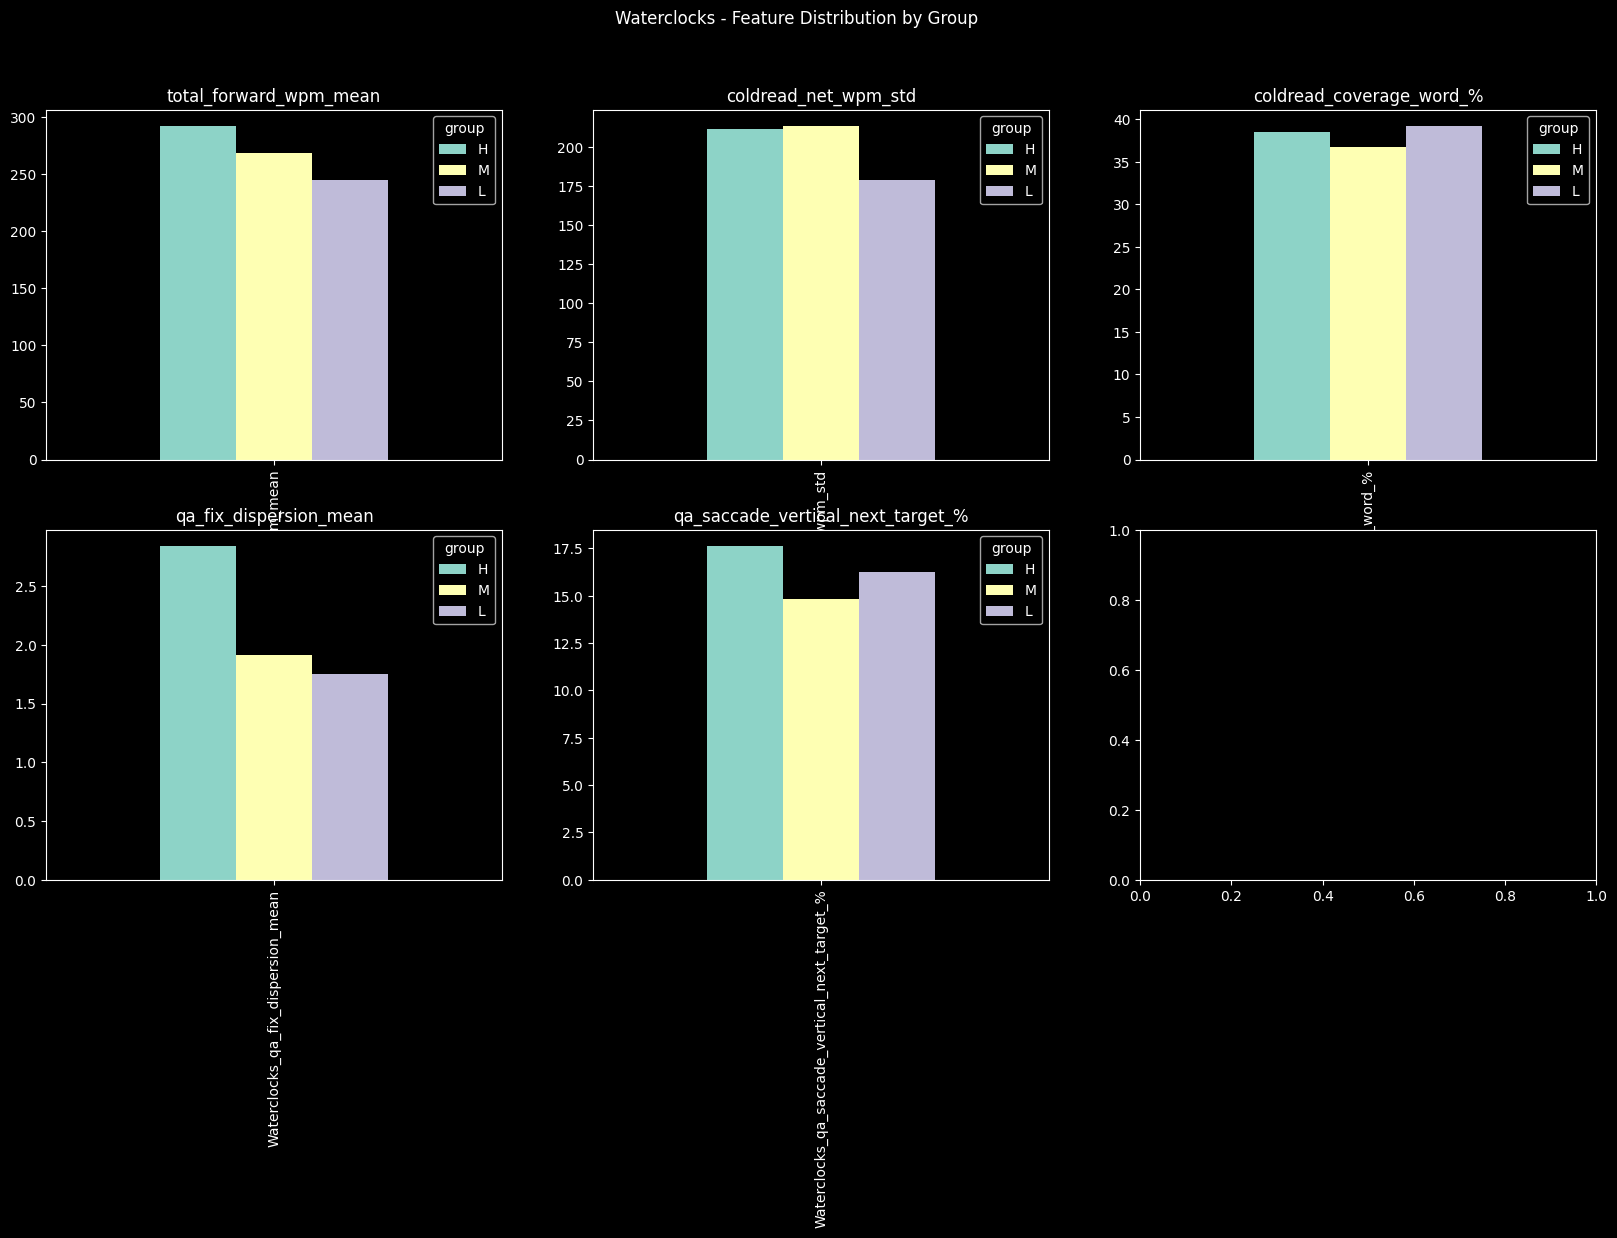

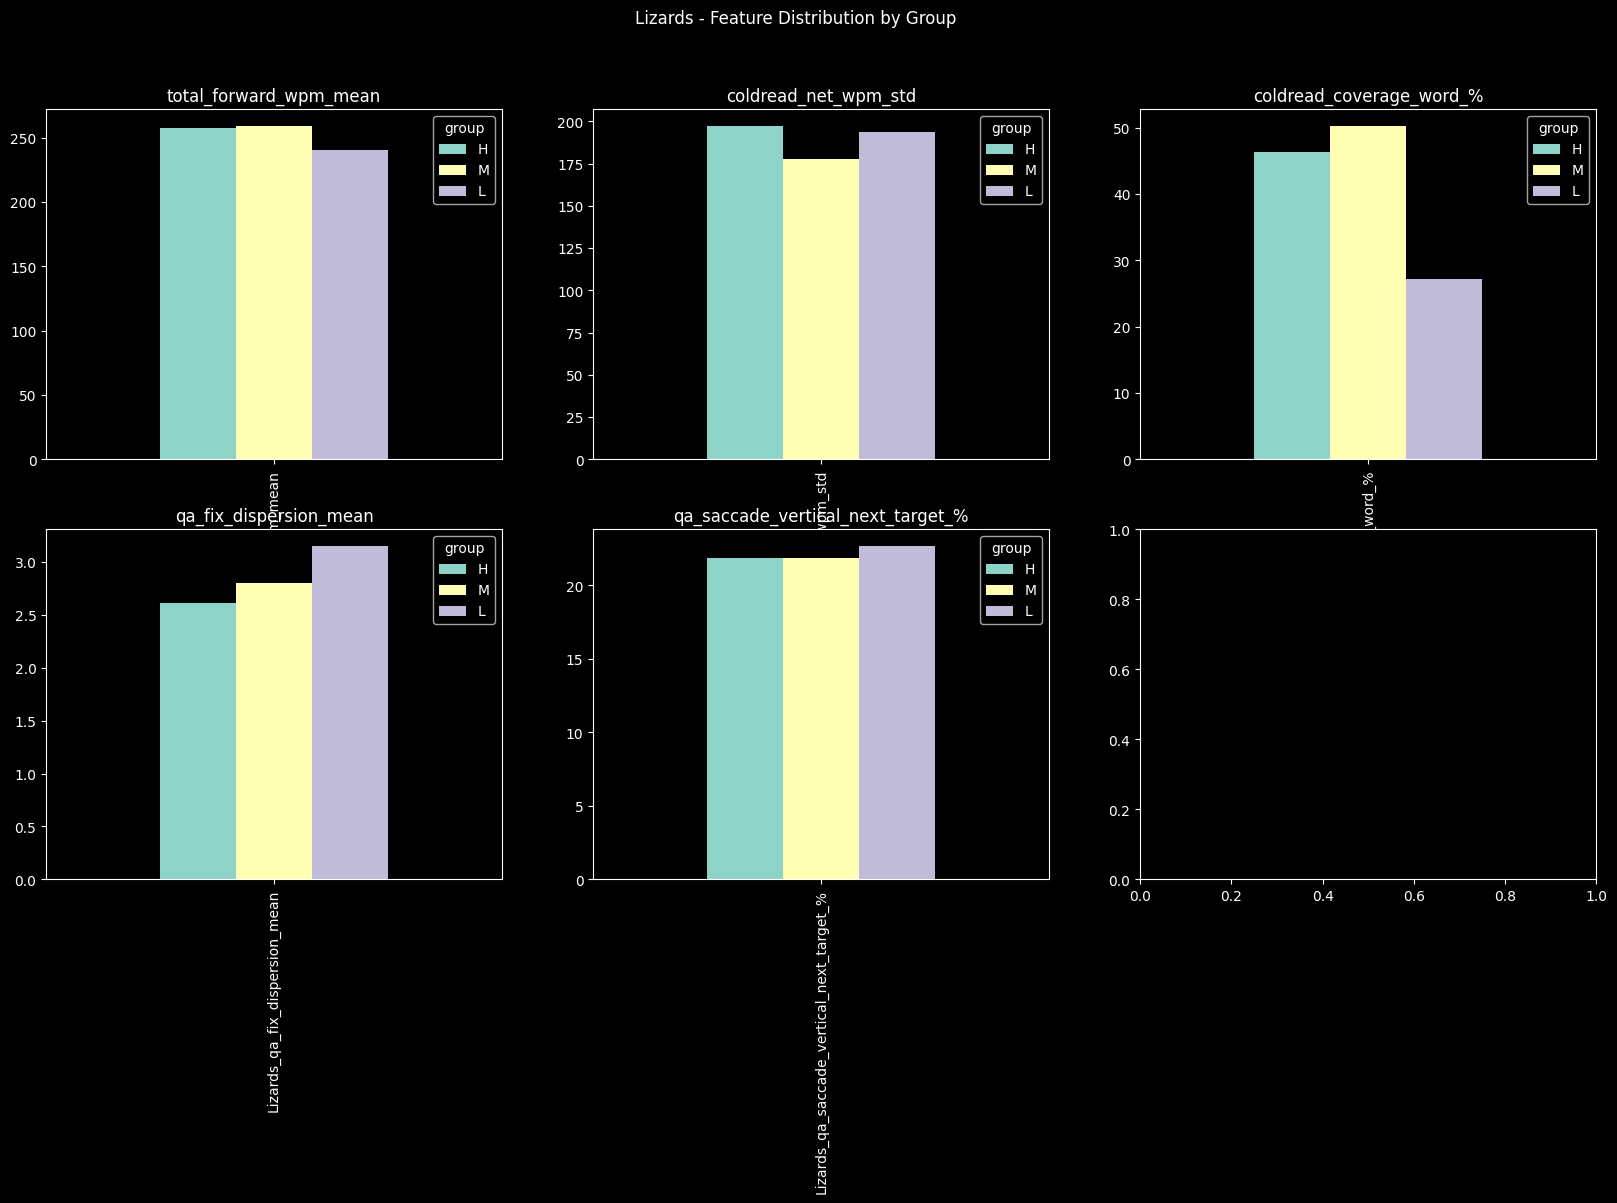

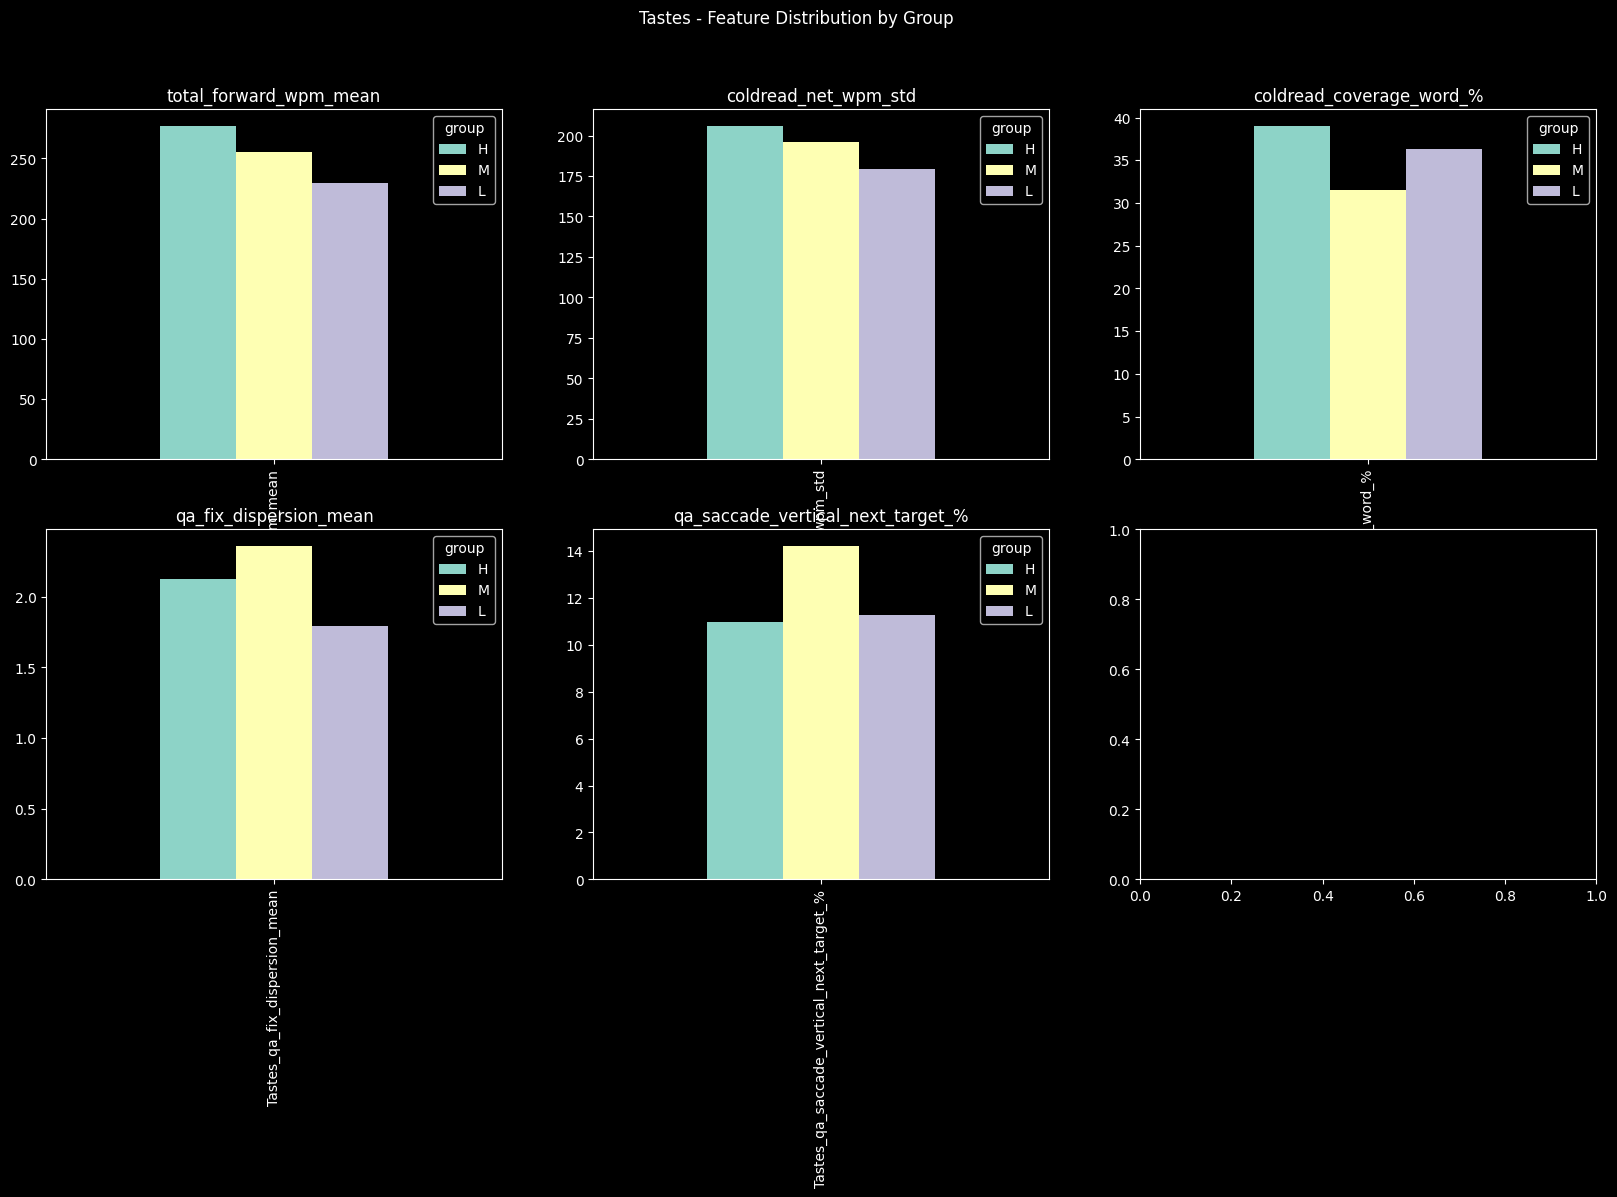

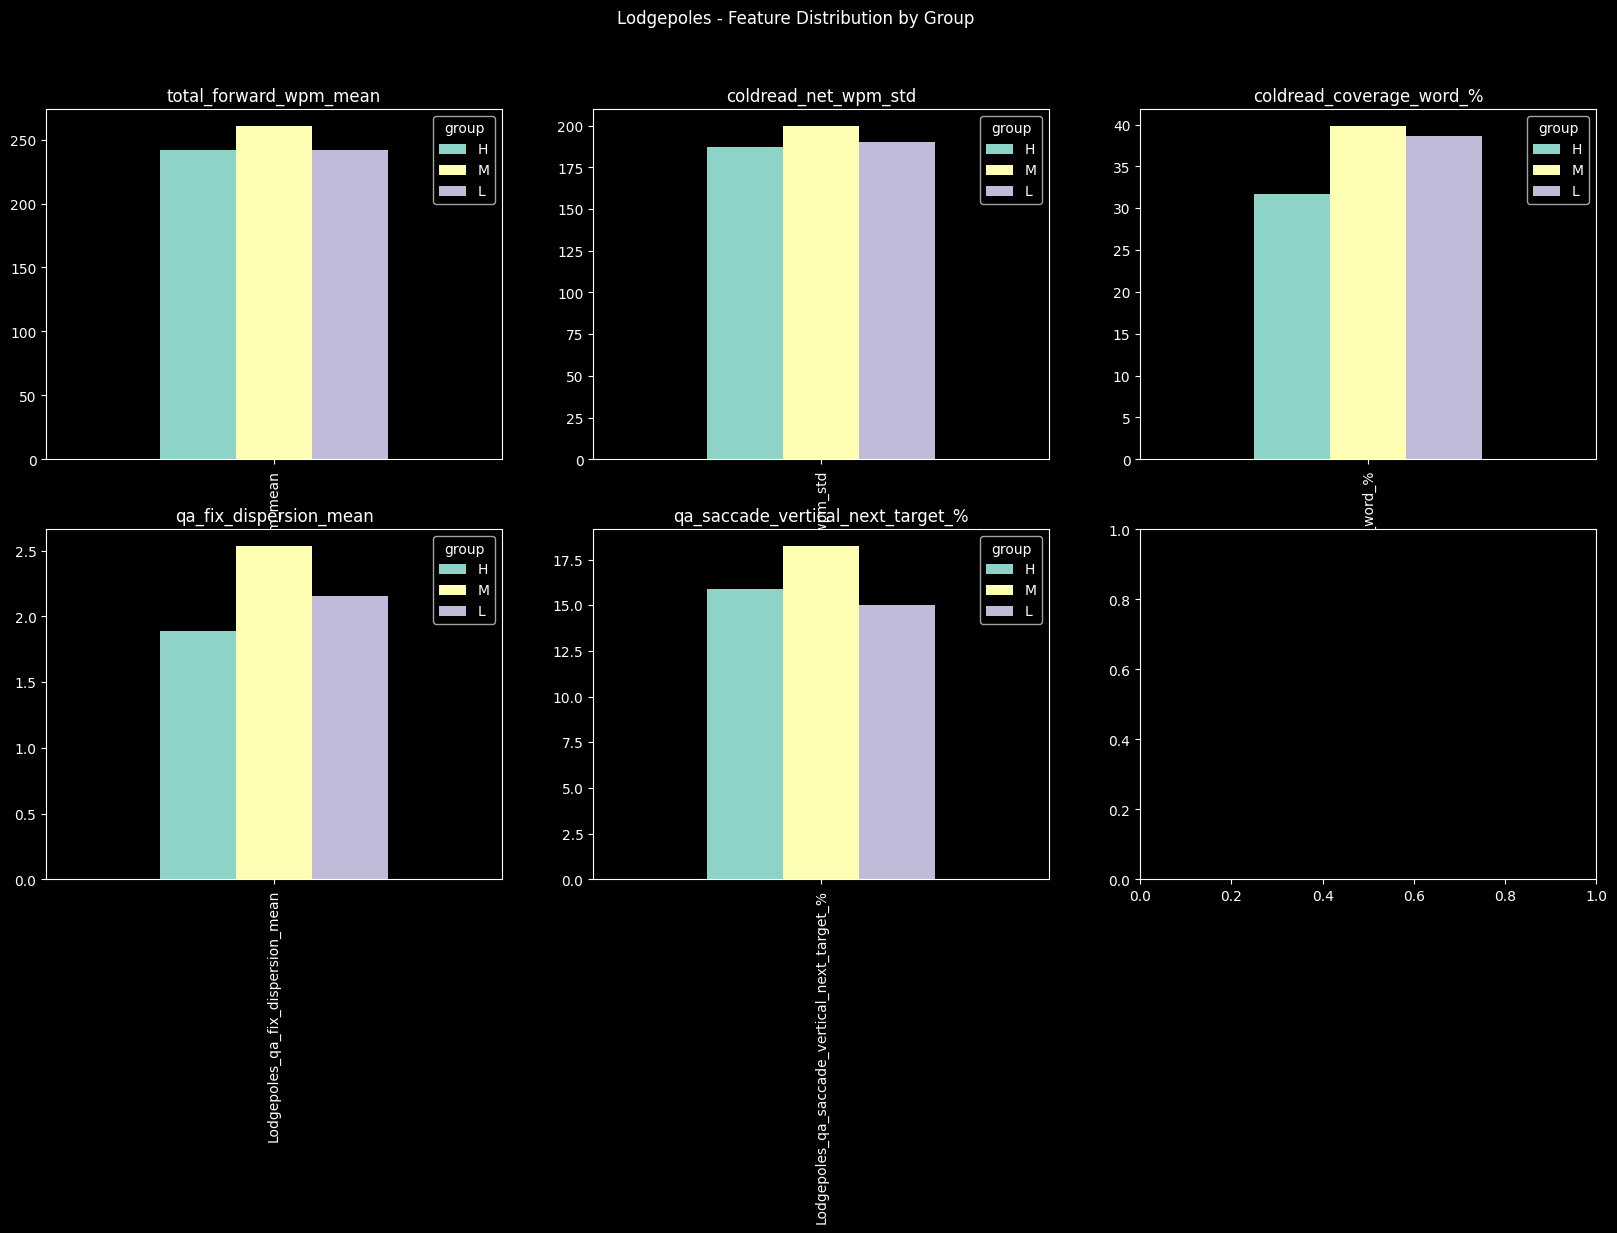

In [6]:
for assignment_name, df in zip(assignment_names, all_dfs):

    # Compute the mean and std of each feature by group
    numeric_df = df.select_dtypes(include='number')
    all_grouped = numeric_df.groupby(df['group']).mean()
    num_of_rows = len(top_features) // 3 + 1

    # Make into subplots and plot each feature separately
    fig, axs = plt.subplots(num_of_rows, 3, figsize=(20, 10))
    fig.suptitle(f'{assignment_name} - Feature Distribution by Group')
    for i, feature in enumerate(top_features):
        feature_df = all_grouped[[f"{assignment_name}_{feature}"]]
        feature_df.loc[['H', 'M', 'L']].T.plot(kind='bar', ax=axs[i//3, i%3], title=feature)

In [7]:
# Load the txts data for each passage
TXT_DIR = "./data/pdfs/txt"
texts = {}
for assignment_name in assignment_names:
    txt = open(f"{TXT_DIR}/{assignment_name}.txt", "r").read()
    texts[assignment_name] = txt

# Load the summaries of the passages
SUMMARY_DIR = "./data/pdfs/summaries"
summaries = {}
for assignment_name in assignment_names:
    txt = open(f"{SUMMARY_DIR}/{assignment_name}.txt", "r").read()
    summaries[assignment_name] = txt

In [ ]:
# Define the prompt for the clasroom-wide report of an assignment
def compute_group_metrics(df, assignment_name):
  metrics = {
    'count': len(df),
    'score_mean': df[f"{assignment_name}_score"].mean(),
    'score_std': df[f"{assignment_name}_score"].std(),
    **{f"{assignment_name}_{feature}": df[f"{assignment_name}_{feature}"].mean() for feature in top_features}
  }

  # Round metrics to 2 decimal places
  metrics = {k: round(v, 2) for k, v in metrics.items()}
  return metrics

def generate_prompt(assignment_name, df, text, summary):

    # Analyze the readability of text
    r = Readability(text)

    # Compute group metrics for H, M, and L students
    group_metrics = {}
    for name, group in df.groupby('group'):
        group_metrics[name] = compute_group_metrics(group, assignment_name)

    # Compute group metrics for ELL students
    ELL_df = df[df['ELL'] == 'Yes']
    ELL_metrics = compute_group_metrics(ELL_df, assignment_name)
    
    prompt = {
      "role": "AI Educational Analyst",
      "task": "Generate a classroom-wide report for a reading assignment based on provided student performance and eye-tracking data. The report should analyze trends, justify key findings, and offer actionable recommendations.",
      "context": {
        "assignment": {
          "title": assignment_name,
          "flesch_kincaid_grade_level": r.flesch_kincaid().grade_level,
          "word_count": len(text.split()),
          "summary": summary
        },
        "class_summary": {
          "total_students": len(df),
          "high_performers": group_metrics['H'],
          "mid_performers": group_metrics['M'],
          "low_performers": group_metrics['L']
        },
        "special_groups": {
          "ELL_students": ELL_metrics
        }
      },
      "analysis_requirements": {
        "performance_summary": "Provide a structured breakdown of high, mid, and low performers, relating their performance to reading difficulty and content knowledge.",
        "eye_tracking_analysis": f"Analyze eye-tracking behaviors and justify how they correlate with comprehension. Provide a clear justification for how features like [{top_features}] influence reading efficiency.",
        "special_group_analysis": "Examine trends among ELL students, compare their performance to the class average, and justify why these trends exist.",
        "recommendations": {
          "for_high_performers": "Suggest advanced activities and enrichment opportunities.",
          "for_mid_performers": "Recommend comprehension scaffolds and targeted interventions.",
          "for_low_performers": "Provide structured reading strategies and additional supports.",
          "for_ELL_students": "Offer bilingual resources, pre-reading support, and vocabulary aids.",
        }
      },
      "output_format": {
        "title": f"Classroom-Wide Report: {assignment_name}",
        "sections": [
          {
            "header": "📊 Class Performance Overview",
            "content": "Summarize the class-wide reading assignment performance, breaking it down into high, mid, and low performers. Provide an overall accuracy rate and trends in reading comprehension."
          },
          {
            "header": "🔍 Eye-Tracking Insights",
            "content": f"Analyze how eye-tracking metrics differ across high, mid, and low performers. Justify why variations in [{top_features}] indicate specific reading behaviors."
          },
          {
            "header": "🧑‍🎓 ELL Considerations",
            "content": "Examine how ELL performed in comparison to their peers. Justify observed patterns using known reading science principles."
          },
          {
            "header": "📢 Actionable Teaching Recommendations",
            "content": "Provide targeted reading strategies for different groups based on their performance. Each recommendation should be justified with classroom relevance."
          }
        ]
      }
    }
    return prompt

for assignment_name, df in zip(assignment_names, all_dfs):
    text = texts[assignment_name]
    summary = summaries[assignment_name]
    prompt = generate_prompt(assignment_name, df, text, summary)

    res = ollama.chat(
        model="llama3",
        messages=[
            {
                "role": "user",
                "content": json.dumps(prompt)
            }
        ]
    )
    print(res)
    break

model='llama3' created_at='2025-02-08T19:12:36.373665Z' done=True done_reason='stop' total_duration=69406615250 load_duration=814864875 prompt_eval_count=1184 prompt_eval_duration=12826000000 eval_count=898 eval_duration=55762000000 message=Message(role='assistant', content="**Classroom-Wide Report: Suffrage**\n\n**Class Performance Overview**\n\nThe class-wide reading assignment on the topic of suffrage has revealed some interesting trends in student performance. The overall accuracy rate stands at 0.5329, indicating a moderate level of comprehension among students.\n\nBreaking down the class into high, mid, and low performers, we can observe the following:\n\n* **High Performers** (15 students): Score mean: 0.7592592592592592, score std: 0.08825834559583215. These students demonstrated a strong understanding of the text, with an average forward reading speed of 270.30571428571426 words per minute (wpm) and a cold read coverage rate of 36.20866666666667%. Their fixation dispersion mea